# Projeto WebScraping

Projeto responsável por extrair informações do site https://stackoverflow.com/questions. Sendo assim, foi decidido pegar informações diárias do site, para fazer uma análise adequada das questões que são discutidas na atualidade.

In [46]:
# para trabalhar com diretórios / sistema operacional
import os
import re
# para nos comunicarmos com a Web
import requests

# para extrair informações de páginas HTML
import bs4
from bs4 import BeautifulSoup

# utilizada para nos indicar o caminho do executável do Python
import sys

# Para criar um Data Frame
import pandas as pd

# Controlar espera entre requisições
import time

# Gerar valores aleatórios
import random

# Produto cartesiano
from sklearn.utils.extmath import cartesian

# Renderizar HTML
import IPython

# Biblioteca para data de hoje
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

### Data de Hoje

Essa será a data em que será feita toda a análise.

In [2]:
data_atual = str(date.today())
print(f'A data de hoje é: {data_atual}')

A data de hoje é: 2023-05-17


## 1. Extração

### Coração da Extração

Responsável por pegar diretamente do site as informações. Observe que é importante definir `n`, número total dos dados, e `p`, número total da amostra. Além disso, na `lista_tag_noticia` é armazenado informações para extração de título, data e tags. Enquanto isso, na `lista_estatisticas` é armazenado informações sobre views, answers e votes nas questões apontadas pelos usuários. **Rode esta célula apenas uma vez**.

In [3]:
headers = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})

lista_tag_noticia = []
lista_estatisticas = []
n = 500
p = 1
for i in range(0, n, p):
    # extraindo paginas com requests
    url = f'https://stackoverflow.com/questions?tab=active&page={i}'
    resposta = requests.get(url=url, headers=headers)
    resposta.encoding = 'utf-8'
    
    #pegando informações com soup
    soup = BeautifulSoup(resposta.text, 'html.parser')
    lista_tag_noticia.append(soup.find_all('div', class_ = 's-post-summary--content'))
    lista_estatisticas.append(soup.find_all('div', class_ = 's-post-summary--stats js-post-summary-stats'))

Parte responsável para o ajuste de dados brutos em dados adequados para análise das estatísticas (views, answers e votes).

In [7]:
lista_votes = []

for j in range(0, n, p):
    lista_estatisticas_bkp_1 = lista_estatisticas[j]
    lista_tag_noticia_bkp_2 = lista_tag_noticia[j]
    for i in range(0, len(lista_estatisticas_bkp_1)):

        tags_questions_1 = lista_estatisticas_bkp_1[i]
        tags_questions_2 = lista_tag_noticia_bkp_2[i]
        data_hora = re.search(r'\d{4}-\d{2}-\d{2}', tags_questions_2.find('time').find('span')['title']).group()  
        if data_hora == data_atual:
            vote = tags_questions_1.find_all('span', class_='s-post-summary--stats-item-number')
            lista_votes.append(vote)

Parte responsável para o ajuste de dados brutos em dados adequados para análise das estatísticas (título, data e tags).

In [8]:
lista_titulo = []
lista_tags = []
lista_data = []

for j in range(0, n, p):
    lista_tag_noticia_bkp = lista_tag_noticia[j]
    for i in range(0, len(lista_tag_noticia_bkp)):

        tags_questions = lista_tag_noticia_bkp[i]
        data_hora = re.search(r'\d{4}-\d{2}-\d{2}', tags_questions.find('time').find('span')['title']).group()  
        
        if data_hora == data_atual:
            titulo = tags_questions.find('h3').text
            titulo = titulo.replace('\n', '') #limpa os ENTERS a esquerda e direita
            lista_titulo.append(titulo)

            tags = tags_questions.find_all('li', class_='d-inline mr4 js-post-tag-list-item')
            lista_tags.append(tags)

            lista_data.append(data_hora)

### Criando DataFrame

In [52]:
df = pd.DataFrame({'titulo': lista_titulo,
                   'Tags': lista_tags,
                   'data': lista_data,
                   'Estatisticas': lista_votes
                  })

In [53]:
df

,titulo,Tags,data,Estatisticas
0,How to select the weekly wise record in one mo...,"[[[sql]], [[mysql]], [[database]]]",2023-05-17,"[[0], [0], [5]]"
1,"I'm trying to make a click event with jquery, ...",[[[jquery]]],2023-05-17,"[[0], [1], [24]]"
2,How can I send data from html forms with multi...,"[[[javascript]], [[html]], [[html-email]]]",2023-05-17,"[[0], [0], [2]]"
3,Heroku redis update throws certificate error,"[[[node.js]], [[ssl]], [[heroku]], [[redis]]]",2023-05-17,"[[0], [0], [2]]"
4,Snowflake Information_Schema - Getting client ...,"[[[sql]], [[snowflake-cloud-data-platform]]]",2023-05-17,"[[0], [1], [29]]"
...,...,...,...,...
6916,VBA Excel Random Number Generator No Duplicate...,"[[[excel]], [[vba]], [[random]]]",2023-05-17,"[[-1], [0], [38]]"
6917,How can I connect two different Traefik instan...,"[[[docker]], [[networking]], [[server]], [[dns...",2023-05-17,"[[0], [0], [8]]"
6918,Trait to detect if a function type is maked no...,"[[[c++]], [[function]], [[template-meta-progra...",2023-05-17,"[[6], [2], [374]]"
6919,New JDBC index not appearing in Kibana's Disco...,"[[[logstash]], [[kibana]], [[elk]], [[logstash...",2023-05-17,"[[0], [0], [7]]"


In [54]:
# Transforma tags html em tags str
df.Tags[0]

[<li class="d-inline mr4 js-post-tag-list-item"><a aria-label="show questions tagged 'sql'" aria-labelledby="tag-sql-tooltip-container" class="post-tag flex--item mt0 js-tagname-sql" href="/questions/tagged/sql" rel="tag" title="show questions tagged 'sql'">sql</a></li>,
 <li class="d-inline mr4 js-post-tag-list-item"><a aria-label="show questions tagged 'mysql'" aria-labelledby="tag-mysql-tooltip-container" class="post-tag flex--item mt0 js-tagname-mysql" href="/questions/tagged/mysql" rel="tag" title="show questions tagged 'mysql'">mysql</a></li>,
 <li class="d-inline mr4 js-post-tag-list-item"><a aria-label="show questions tagged 'database'" aria-labelledby="tag-database-tooltip-container" class="post-tag flex--item mt0 js-tagname-database" href="/questions/tagged/database" rel="tag" title="show questions tagged 'database'">database</a></li>]

### Manipulação dos Dados

In [55]:
# Função lambda para extrair os valores da lista
extract_values = lambda x: [item.text for item in x]

# Aplicando a função lambda na coluna 'Tags' e criando uma nova coluna 'tags'
df['tags'] = df['Tags'].apply(lambda x: extract_values(x))

# Exibindo o DataFrame resultante
df

,titulo,Tags,data,Estatisticas,tags
0,How to select the weekly wise record in one mo...,"[[[sql]], [[mysql]], [[database]]]",2023-05-17,"[[0], [0], [5]]","[sql, mysql, database]"
1,"I'm trying to make a click event with jquery, ...",[[[jquery]]],2023-05-17,"[[0], [1], [24]]",[jquery]
2,How can I send data from html forms with multi...,"[[[javascript]], [[html]], [[html-email]]]",2023-05-17,"[[0], [0], [2]]","[javascript, html, html-email]"
3,Heroku redis update throws certificate error,"[[[node.js]], [[ssl]], [[heroku]], [[redis]]]",2023-05-17,"[[0], [0], [2]]","[node.js, ssl, heroku, redis]"
4,Snowflake Information_Schema - Getting client ...,"[[[sql]], [[snowflake-cloud-data-platform]]]",2023-05-17,"[[0], [1], [29]]","[sql, snowflake-cloud-data-platform]"
...,...,...,...,...,...
6916,VBA Excel Random Number Generator No Duplicate...,"[[[excel]], [[vba]], [[random]]]",2023-05-17,"[[-1], [0], [38]]","[excel, vba, random]"
6917,How can I connect two different Traefik instan...,"[[[docker]], [[networking]], [[server]], [[dns...",2023-05-17,"[[0], [0], [8]]","[docker, networking, server, dns, traefik]"
6918,Trait to detect if a function type is maked no...,"[[[c++]], [[function]], [[template-meta-progra...",2023-05-17,"[[6], [2], [374]]","[c++, function, template-meta-programming, c++..."
6919,New JDBC index not appearing in Kibana's Disco...,"[[[logstash]], [[kibana]], [[elk]], [[logstash...",2023-05-17,"[[0], [0], [7]]","[logstash, kibana, elk, logstash-jdbc]"


In [56]:
# Função lambda para extrair os valores da lista
extract_values = lambda x: [item.text for item in x]

# Aplicando a função lambda na coluna 'Estatisticas' e criando uma nova coluna 'estatisticas'
df['estatisticas'] = df['Estatisticas'].apply(lambda x: extract_values(x))

# Exibindo o DataFrame resultante
df

,titulo,Tags,data,Estatisticas,tags,estatisticas
0,How to select the weekly wise record in one mo...,"[[[sql]], [[mysql]], [[database]]]",2023-05-17,"[[0], [0], [5]]","[sql, mysql, database]","[0, 0, 5]"
1,"I'm trying to make a click event with jquery, ...",[[[jquery]]],2023-05-17,"[[0], [1], [24]]",[jquery],"[0, 1, 24]"
2,How can I send data from html forms with multi...,"[[[javascript]], [[html]], [[html-email]]]",2023-05-17,"[[0], [0], [2]]","[javascript, html, html-email]","[0, 0, 2]"
3,Heroku redis update throws certificate error,"[[[node.js]], [[ssl]], [[heroku]], [[redis]]]",2023-05-17,"[[0], [0], [2]]","[node.js, ssl, heroku, redis]","[0, 0, 2]"
4,Snowflake Information_Schema - Getting client ...,"[[[sql]], [[snowflake-cloud-data-platform]]]",2023-05-17,"[[0], [1], [29]]","[sql, snowflake-cloud-data-platform]","[0, 1, 29]"
...,...,...,...,...,...,...
6916,VBA Excel Random Number Generator No Duplicate...,"[[[excel]], [[vba]], [[random]]]",2023-05-17,"[[-1], [0], [38]]","[excel, vba, random]","[-1, 0, 38]"
6917,How can I connect two different Traefik instan...,"[[[docker]], [[networking]], [[server]], [[dns...",2023-05-17,"[[0], [0], [8]]","[docker, networking, server, dns, traefik]","[0, 0, 8]"
6918,Trait to detect if a function type is maked no...,"[[[c++]], [[function]], [[template-meta-progra...",2023-05-17,"[[6], [2], [374]]","[c++, function, template-meta-programming, c++...","[6, 2, 374]"
6919,New JDBC index not appearing in Kibana's Disco...,"[[[logstash]], [[kibana]], [[elk]], [[logstash...",2023-05-17,"[[0], [0], [7]]","[logstash, kibana, elk, logstash-jdbc]","[0, 0, 7]"


In [57]:
# Eliminando colunas repetidas
df = df.drop(columns = ['Tags', 'Estatisticas'])

In [58]:
df

,titulo,data,tags,estatisticas
0,How to select the weekly wise record in one mo...,2023-05-17,"[sql, mysql, database]","[0, 0, 5]"
1,"I'm trying to make a click event with jquery, ...",2023-05-17,[jquery],"[0, 1, 24]"
2,How can I send data from html forms with multi...,2023-05-17,"[javascript, html, html-email]","[0, 0, 2]"
3,Heroku redis update throws certificate error,2023-05-17,"[node.js, ssl, heroku, redis]","[0, 0, 2]"
4,Snowflake Information_Schema - Getting client ...,2023-05-17,"[sql, snowflake-cloud-data-platform]","[0, 1, 29]"
...,...,...,...,...
6916,VBA Excel Random Number Generator No Duplicate...,2023-05-17,"[excel, vba, random]","[-1, 0, 38]"
6917,How can I connect two different Traefik instan...,2023-05-17,"[docker, networking, server, dns, traefik]","[0, 0, 8]"
6918,Trait to detect if a function type is maked no...,2023-05-17,"[c++, function, template-meta-programming, c++...","[6, 2, 374]"
6919,New JDBC index not appearing in Kibana's Disco...,2023-05-17,"[logstash, kibana, elk, logstash-jdbc]","[0, 0, 7]"


In [59]:
# Separando a coluna estatisticas em 'votes', 'answers', 'views', repectivamente.
df[['votes', 'answers', 'views']] = df['estatisticas'].apply(lambda x: pd.Series(x))
df

,titulo,data,tags,estatisticas,votes,answers,views
0,How to select the weekly wise record in one mo...,2023-05-17,"[sql, mysql, database]","[0, 0, 5]",0,0,5
1,"I'm trying to make a click event with jquery, ...",2023-05-17,[jquery],"[0, 1, 24]",0,1,24
2,How can I send data from html forms with multi...,2023-05-17,"[javascript, html, html-email]","[0, 0, 2]",0,0,2
3,Heroku redis update throws certificate error,2023-05-17,"[node.js, ssl, heroku, redis]","[0, 0, 2]",0,0,2
4,Snowflake Information_Schema - Getting client ...,2023-05-17,"[sql, snowflake-cloud-data-platform]","[0, 1, 29]",0,1,29
...,...,...,...,...,...,...,...
6916,VBA Excel Random Number Generator No Duplicate...,2023-05-17,"[excel, vba, random]","[-1, 0, 38]",-1,0,38
6917,How can I connect two different Traefik instan...,2023-05-17,"[docker, networking, server, dns, traefik]","[0, 0, 8]",0,0,8
6918,Trait to detect if a function type is maked no...,2023-05-17,"[c++, function, template-meta-programming, c++...","[6, 2, 374]",6,2,374
6919,New JDBC index not appearing in Kibana's Disco...,2023-05-17,"[logstash, kibana, elk, logstash-jdbc]","[0, 0, 7]",0,0,7


In [62]:
# Transformando as visualizações em inteiros

# Função para substituir valores em formato "k" por inteiros
def substituir_valor(valor):
    if 'k' in valor:
        return float(valor.replace('k', '')) * 1000
    if 'm' in valor:
        return float(valor.replace('m', '')) * 1000000
    else:
        return float(valor)
    
# Aplicar a substituição à coluna
df['views'] = df['views'].apply(lambda x: substituir_valor(x))

### DataFrame Final

In [64]:
# Excluindo colunas que não geram mais valor para a análise
df_clean = df.drop(columns = ['estatisticas', 'data'])

In [65]:
df_clean

,titulo,tags,votes,answers,views
0,How to select the weekly wise record in one mo...,"[sql, mysql, database]",0,0,5.0
1,"I'm trying to make a click event with jquery, ...",[jquery],0,1,24.0
2,How can I send data from html forms with multi...,"[javascript, html, html-email]",0,0,2.0
3,Heroku redis update throws certificate error,"[node.js, ssl, heroku, redis]",0,0,2.0
4,Snowflake Information_Schema - Getting client ...,"[sql, snowflake-cloud-data-platform]",0,1,29.0
...,...,...,...,...,...
6916,VBA Excel Random Number Generator No Duplicate...,"[excel, vba, random]",-1,0,38.0
6917,How can I connect two different Traefik instan...,"[docker, networking, server, dns, traefik]",0,0,8.0
6918,Trait to detect if a function type is maked no...,"[c++, function, template-meta-programming, c++...",6,2,374.0
6919,New JDBC index not appearing in Kibana's Disco...,"[logstash, kibana, elk, logstash-jdbc]",0,0,7.0


## 2. Análise Exploratória

### Tags com mais frequência no dia de hoje

In [66]:
# Função para contar a frequência dos elementos
def contar_elementos(lista):
    frequencia = {}
    for sublist in lista:
        for item in sublist:
            if item in frequencia:
                frequencia[item] += 1
            else:
                frequencia[item] = 1
    return frequencia

# Converter a coluna em uma lista
lista = df_clean['tags'].tolist()

# Contar a frequência dos elementos
contagem = contar_elementos(lista)

# Encontrar o elemento mais frequente
elemento_mais_frequente = max(contagem, key=contagem.get)

In [67]:
print(f'O assunto mais comentado até a primeira execução deste notebook é {elemento_mais_frequente} com uma frequência de aparecimento de {contagem[elemento_mais_frequente]} vezes.')

O assunto mais comentado até a primeira execução deste notebook é python com uma frequência de aparecimento de 951 vezes.


In [68]:
df_1 = pd.DataFrame.from_dict(contagem, orient='index', columns=['Frequência']).sort_values(by='Frequência', ascending=False)
df_1

,Frequência
python,951
javascript,625
java,407
c#,354
reactjs,335
...,...
angular-ui-router,1
hilla,1
docker-registry,1
backtracking,1


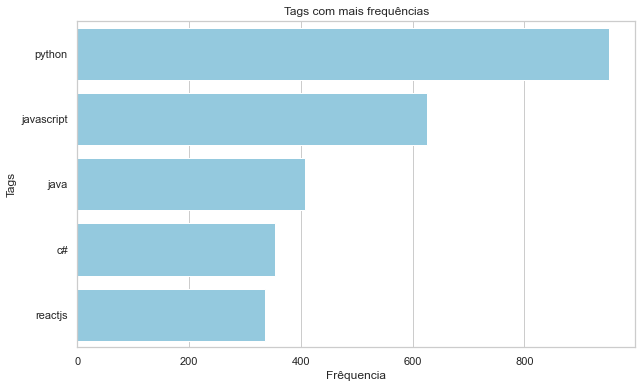

In [69]:
# Configurar o estilo do Seaborn
sns.set(style="whitegrid")

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequência', y=df_1.head(5).index, data=df_1.head(5), color='skyblue')

# Adicionar rótulos aos eixos
plt.xlabel('Frêquencia')
plt.ylabel('Tags')

# Adicionar título ao gráfico
plt.title('Tags com mais frequências')

# Exibir o gráfico
plt.show()

Observe que os cincos assuntos mais comentados, em ordem decrescente, são: `python`, `javascript`, `java`, `c#` e `reactjs`.

### Tags com mais answers no dia de hoje

Neste trecho de código é possível analisar quais tags possuem mais respostas dos usuários. Observe por exemplo que se python aparece em duas linhas do dataframe, os itens correspondentes da coluna de answers, vão ser somados.

In [70]:
# Função para contar a frequência dos elementos e somar os inteiros correspondentes
def contar_elementos_e_respostas(lista, coluna):
    frequencia = {}
    soma_total = {}
    for sublist, valor in zip(lista, coluna):
        for item in sublist:
            if item in frequencia:
                frequencia[item] += 1
                soma_total[item] += int(valor)
            else:
                frequencia[item] = 1
                soma_total[item] = int(valor)
    resultado = {item: [frequencia[item], soma_total[item]] for item in frequencia}
    return resultado

# Converter as colunas em listas
lista1 = df_clean['tags'].tolist()
lista2 = df_clean['answers'].tolist()

# Contar a frequência dos elementos e somar os inteiros correspondentes
resultado = contar_elementos_e_respostas(lista1, lista2)

In [71]:
df_2 = pd.DataFrame.from_dict(resultado, orient='index', columns=['Frequência', 'Respostas']).sort_values(by='Respostas', ascending=False)
df_2

,Frequência,Respostas
python,951,1513
javascript,625,1240
java,407,623
android,283,606
c#,354,523
...,...,...
pentaho-data-integration,1,0
pdi,1,0
vmware-player,1,0
glsl,3,0


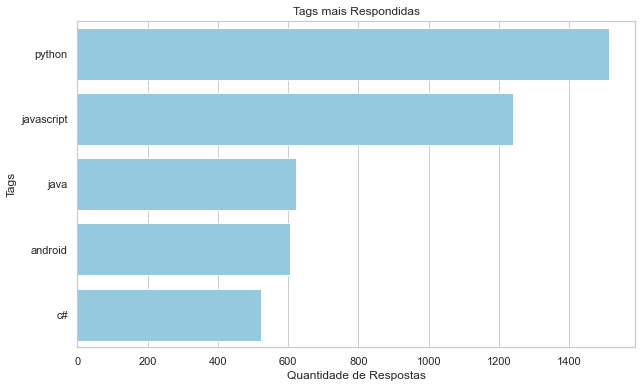

In [72]:
# Configurar o estilo do Seaborn
sns.set(style="whitegrid")

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
sns.barplot(x='Respostas', y=df_2.head(5).index, data=df_2.head(5), color='skyblue')

# Adicionar rótulos aos eixos
plt.xlabel('Quantidade de Respostas')
plt.ylabel('Tags')

# Adicionar título ao gráfico
plt.title('Tags mais Respondidas')

# Exibir o gráfico
plt.show()

A partir da tabela acima podemos fazer a seguinte pergunta: **Tags com muita frequência, consequentemente, tem mais respostas?** 

<br>
Podemos analisar que trazendo em ordem decrescente as tags com mais respostas, houve pequenas mudanças, pois apenas o assunto android chegou a ser entre os mais respondidos. Entrentanto, os outros se mantiveram no top 5, porque possuem uma frequência maior de aparição.

### Tags com mais visualizações no dia de hoje

In [75]:
# Converter as colunas em listas
lista1 = df_clean['tags'].tolist()
lista2 = df_clean['views'].tolist()

# Contar a frequência dos elementos e somar os inteiros correspondentes
resultado = contar_elementos_e_respostas(lista1, lista2)
df_3 = pd.DataFrame.from_dict(resultado, orient='index', columns=['Frequência', 'Views']).sort_values(by='Views', ascending=False)
df_3

,Frequência,Views
python,951,15507285
javascript,625,13245590
html,224,6026162
git,69,4411484
c#,354,4344094
...,...,...
paste,1,2
ehcache-2,1,2
activiti,1,2
activiti-cloud,1,2


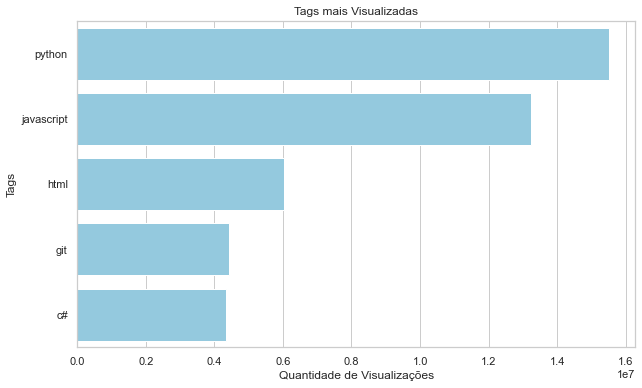

In [77]:
# Configurar o estilo do Seaborn
sns.set(style="whitegrid")

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
sns.barplot(x='Views', y=df_3.head(5).index, data=df_3.head(5), color='skyblue')

# Adicionar rótulos aos eixos
plt.xlabel('Quantidade de Visualizações')
plt.ylabel('Tags')

# Adicionar título ao gráfico
plt.title('Tags mais Visualizadas')

# Exibir o gráfico
plt.show()

### Tags com mais votos no dia de hoje

In [78]:
# Converter as colunas em listas
lista1 = df_clean['tags'].tolist()
lista2 = df_clean['votes'].tolist()

# Contar a frequência dos elementos e somar os inteiros correspondentes
resultado = contar_elementos_e_respostas(lista1, lista2)
df_4 = pd.DataFrame.from_dict(resultado, orient='index', columns=['Frequência', 'Votes']).sort_values(by='Votes', ascending=False)
df_4

,Frequência,Votes
python,951,15942
javascript,625,11144
git,69,5928
oop,17,4556
python-decorators,1,4528
...,...,...
pine-script,10,-9
train-test-split,1,-9
lightgbm,2,-10
pine-script-v5,8,-11


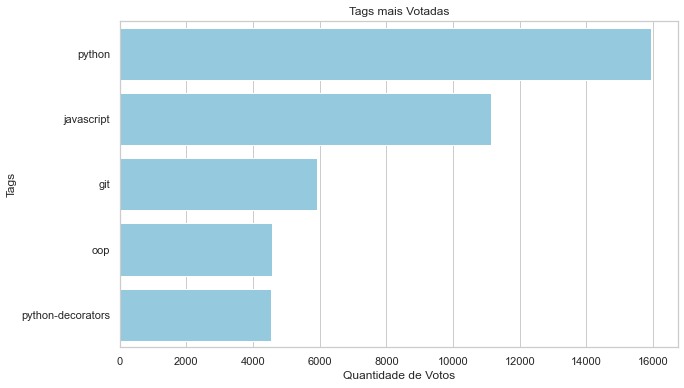

In [79]:
# Configurar o estilo do Seaborn
sns.set(style="whitegrid")

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
sns.barplot(x='Votes', y=df_4.head(5).index, data=df_4.head(5), color='skyblue')

# Adicionar rótulos aos eixos
plt.xlabel('Quantidade de Votos')
plt.ylabel('Tags')

# Adicionar título ao gráfico
plt.title('Tags mais Votadas')

# Exibir o gráfico
plt.show()

### Análise completa das Tags

In [84]:
df_concat = pd.DataFrame({'titulo': df_1['Frequência'].tolist(),
                   'Tags': df_2.Respostas.tolist(),
                   'data': df_3.Views.tolist(),
                   'Estatisticas': df_4.Votes.tolist()
                  })

In [85]:
df_concat

,titulo,Tags,data,Estatisticas
0,951,1513,15507285,15942
1,625,1240,13245590,11144
2,407,623,6026162,5928
3,354,606,4411484,4556
4,335,523,4344094,4528
...,...,...,...,...
5375,1,0,2,-9
5376,1,0,2,-9
5377,1,0,2,-10
5378,1,0,2,-11
